In [12]:
import drjit as dr
import mitsuba as mi
import numpy as np
import matplotlib.pyplot as plt

mi.set_variant('cuda_ad_rgb')


In [13]:
scene = mi.load_file(r'C:\Users\HTCV_DIRME\Desktop\Projectwork\Blender_xml\Swimming_monke.xml')

print('I am here')

initial_image = mi.render(scene, spp=512)
initial_image_8bit = (np.clip(initial_image, 0, 1) * 255).astype(np.uint8)
bitmap = mi.util.convert_to_bitmap(initial_image_8bit)
bitmap.write(r'C:\Users\HTCV_DIRME\Desktop\Projectwork\rendered and invrend images\initial_rendered_image.png')
print('Initial image rendered and saved')


I am here
Initial image rendered and saved


In [14]:
mi.util.convert_to_bitmap(initial_image)


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [1920, 1080],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 5.93 MiB of image data ]
]

In [15]:
params = mi.traverse(scene)
#print(params)
keys = {
        'Monke_color' : 'elm__8.bsdf.brdf_0.base_color.value',
       'Sphere_color' : 'elm__6.bsdf.brdf_0.base_color.value', 
        'Monke_metallic' : 'elm__6.bsdf.brdf_0.metallic.value' 
        }
original_values = {
    key: params[keys[key]] if 'color' not in key else mi.Color3f(params[keys[key]])
    for key in keys
}
params[keys['Sphere_color']] = mi.Color3f(0.7, 0.2, 0.9)  
params[keys['Monke_metallic']] = 0.5  
params[keys['Monke_color']] = mi.Color3f(0.6, 0.2, 0.9)  
params.update()
print(f"Updated parameters: Monkey Metallic = {params[keys['Monke_metallic']]}, "
      f"Monke Color = {params[keys['Monke_color']]}, "
      f"Sphere Color = {params[keys['Sphere_color']]}")



Updated parameters: Monkey Metallic = [0.5], Monke Color = [[0.009999999776482582, 0.20000000298023224, 0.8999999761581421]], Sphere Color = [[0.009999999776482582, 0.20000000298023224, 0.8999999761581421]]


In [25]:
updated_image = mi.render(scene, spp=512)
updated_image_8bit = (np.clip(updated_image, 0, 1) * 255).astype(np.uint8)
bitmap = mi.util.convert_to_bitmap(updated_image_8bit)
bitmap.write(r'C:\Users\HTCV_DIRME\Desktop\Projectwork\rendered and invrend images\updated_image_with_color_and_metallic_properties.png')
print('Updated image rendered and saved')
mi.util.convert_to_bitmap(updated_image_8bit)

Updated image rendered and saved


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [1920, 1080],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 5.93 MiB of image data ]
]

In [26]:
opt = mi.ad.Adam(lr=0.05)
for key in keys:
    opt[keys[key]] = params[keys[key]]

params.update(opt)

[(UniformSpectrum[value=[0.293539]], {'value'}),
 (SRGBReflectanceSpectrum[
    value = [[0.00479666, 0.965891, 0.210937]]
  ],
  {'value'}),
 (SRGBReflectanceSpectrum[
    value = [[0.209462, 0.801578, 0.406334]]
  ],
  {'value'}),
 (Principled BSDF :
  base_color: SRGBReflectanceSpectrum[
    value = [[0.00479666, 0.965891, 0.210937]]
  ],
  spec_trans: UniformSpectrum[value=[0]],
  anisotropic: UniformSpectrum[value=[0]],
  roughness: UniformSpectrum[value=[0.81]],
  sheen: UniformSpectrum[value=[0]],
  sheen_tint: SRGBReflectanceSpectrum[
    value = [[1, 1, 1]]
  ],
  flatness: UniformSpectrum[value=[0]],
  specular: [0.5],
  clearcoat: UniformSpectrum[value=[0]],
  clearcoat_gloss: UniformSpectrum[value=[0.0009]],
  metallic: UniformSpectrum[value=[0.293539]],
  spec_tint: SRGBReflectanceSpectrum[
    value = [[1, 1, 1]]
  ],,
  {'base_color', 'metallic'}),
 (Principled BSDF :
  base_color: SRGBReflectanceSpectrum[
    value = [[0.209462, 0.801578, 0.406334]]
  ],
  spec_trans: U

In [27]:
def mse(image):
    return dr.mean(dr.sqr(image - initial_image))

iterations = 50
error = {key: [] for key in keys}
intermediate_images = [initial_image_8bit]


In [28]:
for it in range(iterations):
    image = mi.render(scene, params, spp=4)
    loss = mse(image)
    
    print(f"Iteration {it}: Loss = {loss}")  # Check loss value

    dr.backward(loss)
    opt.step()

    # Update and clamp parameter values
    for key in keys:
        if 'color' not in key:
            opt[keys[key]] = dr.clamp(opt[keys[key]], 0.0, 1.0)  # Clamp scalar parameters
        else:
            opt[keys[key]] = mi.Color3f(
                dr.clamp(opt[keys[key]][0], 0.0, 1.0),
                dr.clamp(opt[keys[key]][1], 0.0, 1.0),
                dr.clamp(opt[keys[key]][2], 0.0, 1.0)
            )  # Clamp color values
        params.update(opt)

    # Compute parameter errors
    for key in keys:
        if 'color' not in key:
            err_ref = dr.sum(dr.sqr(original_values[key] - params[keys[key]]))
        else:
            err_ref = dr.sum(dr.sqr(original_values[key] - mi.Color3f(params[keys[key]])))
        print(f"Iteration {it:02d}: {key} parameter error = {err_ref[0]:6f}")
        error[key].append(err_ref)

    # Save intermediate images every 5 iterations
    if (it + 1) % 5 == 0:
        intermediate_image_8bit = (np.clip(image, 0, 1) * 255).astype(np.uint8)
        intermediate_images.append(intermediate_image_8bit)
        save_path = rf'C:\Users\HTCV_DIRME\Desktop\Projectwork\rendered and invrend images\intermediate_image_{it + 1}.png'
        bitmap = mi.util.convert_to_bitmap(intermediate_image_8bit)
        bitmap.write(save_path)
        print(f'\nIntermediate image saved at iteration {it + 1}: {save_path}')

Iteration 0: Loss = [0.0007757987477816641]
Iteration 00: Monke_color parameter error = 0.003868
Iteration 00: Sphere_color parameter error = 0.015064
Iteration 00: Monke_metallic parameter error = 0.000000
Iteration 1: Loss = [0.0008082482381723821]
Iteration 01: Monke_color parameter error = 0.000955
Iteration 01: Sphere_color parameter error = 0.022088
Iteration 01: Monke_metallic parameter error = 0.000000
Iteration 2: Loss = [0.0007377456640824676]
Iteration 02: Monke_color parameter error = 0.000670
Iteration 02: Sphere_color parameter error = 0.034483
Iteration 02: Monke_metallic parameter error = 0.000000
Iteration 3: Loss = [0.0007152335019782186]
Iteration 03: Monke_color parameter error = 0.001701
Iteration 03: Sphere_color parameter error = 0.039089
Iteration 03: Monke_metallic parameter error = 0.000000
Iteration 4: Loss = [0.0007331494707614183]
Iteration 04: Monke_color parameter error = 0.001474
Iteration 04: Sphere_color parameter error = 0.034857
Iteration 04: Monke_m

In [29]:
mi.util.convert_to_bitmap(final_image_8bit)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [1920, 1080],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 5.93 MiB of image data ]
]

In [30]:
final_image = mi.render(scene, spp=512)
final_image_8bit = (np.clip(final_image, 0, 1) * 255).astype(np.uint8)

bitmap = mi.util.convert_to_bitmap(final_image_8bit)
bitmap.write(r'C:\Users\HTCV_DIRME\Desktop\Projectwork\rendered and invrend images\recovered_image_with_color_and_metallic_property.png')
print('\nFinal image rendered and saved')
mi.util.convert_to_bitmap(final_image_8bit)


Final image rendered and saved


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [1920, 1080],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 5.93 MiB of image data ]
]

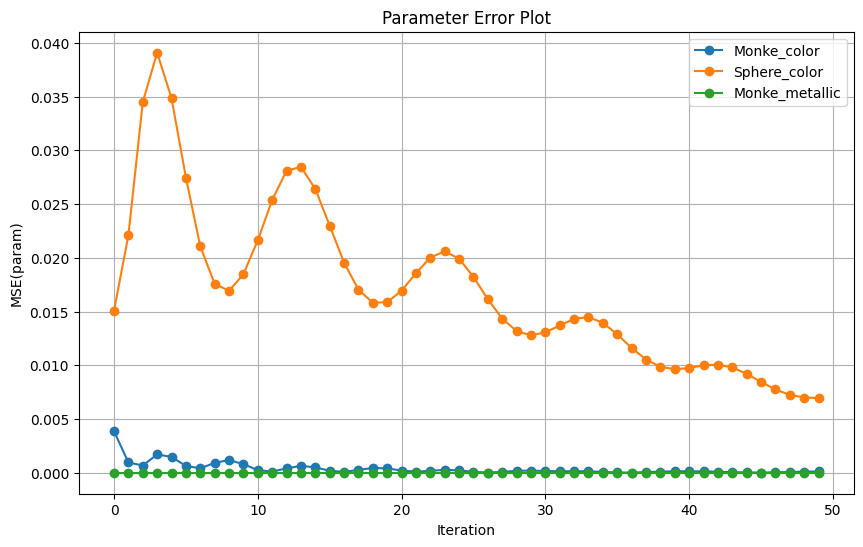

Error plot saved at: C:\Users\HTCV_DIRME\Desktop\Projectwork\rendered and invrend images\parameter_error_plot_with_color.png


In [31]:
plt.figure(figsize=(10, 6))
for key in keys:
    plt.plot(error[key], marker='o', label=key)
plt.xlabel('Iteration')
plt.ylabel('MSE(param)')
plt.title('Parameter Error Plot')
plt.legend()
plt.grid(True)

# Save the error plot
save_path_error_plot = r'C:\Users\HTCV_DIRME\Desktop\Projectwork\rendered and invrend images\parameter_error_plot_with_color.png'
plt.savefig(save_path_error_plot, format='png', dpi=300)
plt.show()

print(f"Error plot saved at: {save_path_error_plot}")